# CR_to_LV.ipynb
Notebook to analyze the data of the mapped networks

In [1]:
# import of necessary files from other folders

import os
import sys
import ast

# libraries imports

import importlib
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import seaborn as sns
import pandas as pd
import pickle

from IPython.display import Image, display
from PIL import Image
from pathlib import Path
from scipy.integrate import solve_ivp
from matplotlib.colors import LinearSegmentedColormap,TwoSlopeNorm


# Set default figure and axes background color to white
plt.rcParams['figure.facecolor'] = 'white'  # Background for the entire figure
plt.rcParams['axes.facecolor'] = 'white' 

In [2]:
# Function to check if a string can be converted to a float or an integer
def is_number(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

# Import complete dataset as a dataframe

In [23]:
# Path to the results directory
results_directory_path = Path('insert_base_path/CRIMMES/MODEL/Data/CR_to_LV_results')

# Definition of DataFrame columns
columns = ['n_supplied','n_consumed','n_produced','structure','leakage','replica','param_dict','C','D','N_cr','R_cr','N_lv','A','g']
df_complete = pd.DataFrame(columns=columns)

# List to accumulate the data
rows = []

# Get all folders and sort them alphabetically
folders = sorted(results_directory_path.iterdir(), key=lambda x: x.name)

# Loop over all items in the sorted list of folders
for folder in folders:
    if folder.is_dir():

        parameters = folder.name
        
        # Check and convert only the parts that can be numbers (floats or integers)
        parameters_list = [float(value) if '.' in value else int(value) for value in parameters.split('_') if is_number(value)]
        
        # Construct the full path of the pickle file
        pickle_file_path = folder / 'all_data.pkl'
        
        if pickle_file_path.exists():
            # Load data from the pickle file
            with open(pickle_file_path, 'rb') as file:
                data = pickle.load(file)

            n_supplied = data['n_supplied'][0],
            n_consumed = data['n_consumed'][0],
            n_produced = data['n_produced'][0],
            structure =  data['structure'][0],
            leakage   =  data['leakage'][0],
            replica   =  data['replica'][0],
            parameters = data['parameters'],
            C = data['uptake'],
            D = data['D'],
            R_cr = data['CR_R'], 
            N_cr = np.array(data['CR_N']), 
            N_lv = np.array(data['LV']),
            g = data['g0'],
            A = data['A']
        
            # Create a new row and add it to the rows list
            new_row = [n_supplied[0]]+[n_consumed[0]]+[n_produced[0]]+[structure[0]]+[leakage[0]]+[replica[0]]+[parameters]+[C]+[D]+[N_cr]+[R_cr]+[N_lv]+[A]+[g]
            rows.append(new_row)

# Create a new DataFrame with the accumulated rows
df_complete = pd.concat([df_complete, pd.DataFrame(rows, columns=columns)], ignore_index=True)

In [24]:
print(len(df_complete))
df_complete.head()


1


,n_supplied,n_consumed,n_produced,structure,leakage,replica,param_dict,C,D,N_cr,R_cr,N_lv,A,g
0,8,2,3,1,1,1,"({'w': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","([[0.2969797664746758, 0.0, 0.0, 0.0, 0.0, 0.0...","([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","([[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [5...","([[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 1...","([[1.0, 30.293513778653676, 30.406398119299592...","[[-0.00411023707082115, 0.0014012954396379243,...","([0.04809114505591825, 0.10907754709619237, 0...."


## Visualize time series

If the dataframe is big, only select a random subset to visualize

In [25]:
if len(df_complete)>20:
    # choose 100 random to plot compared
    import random
    indexes_random = random.sample(list(df_complete.index), 20)
else:
    indexes_random = df_complete.index

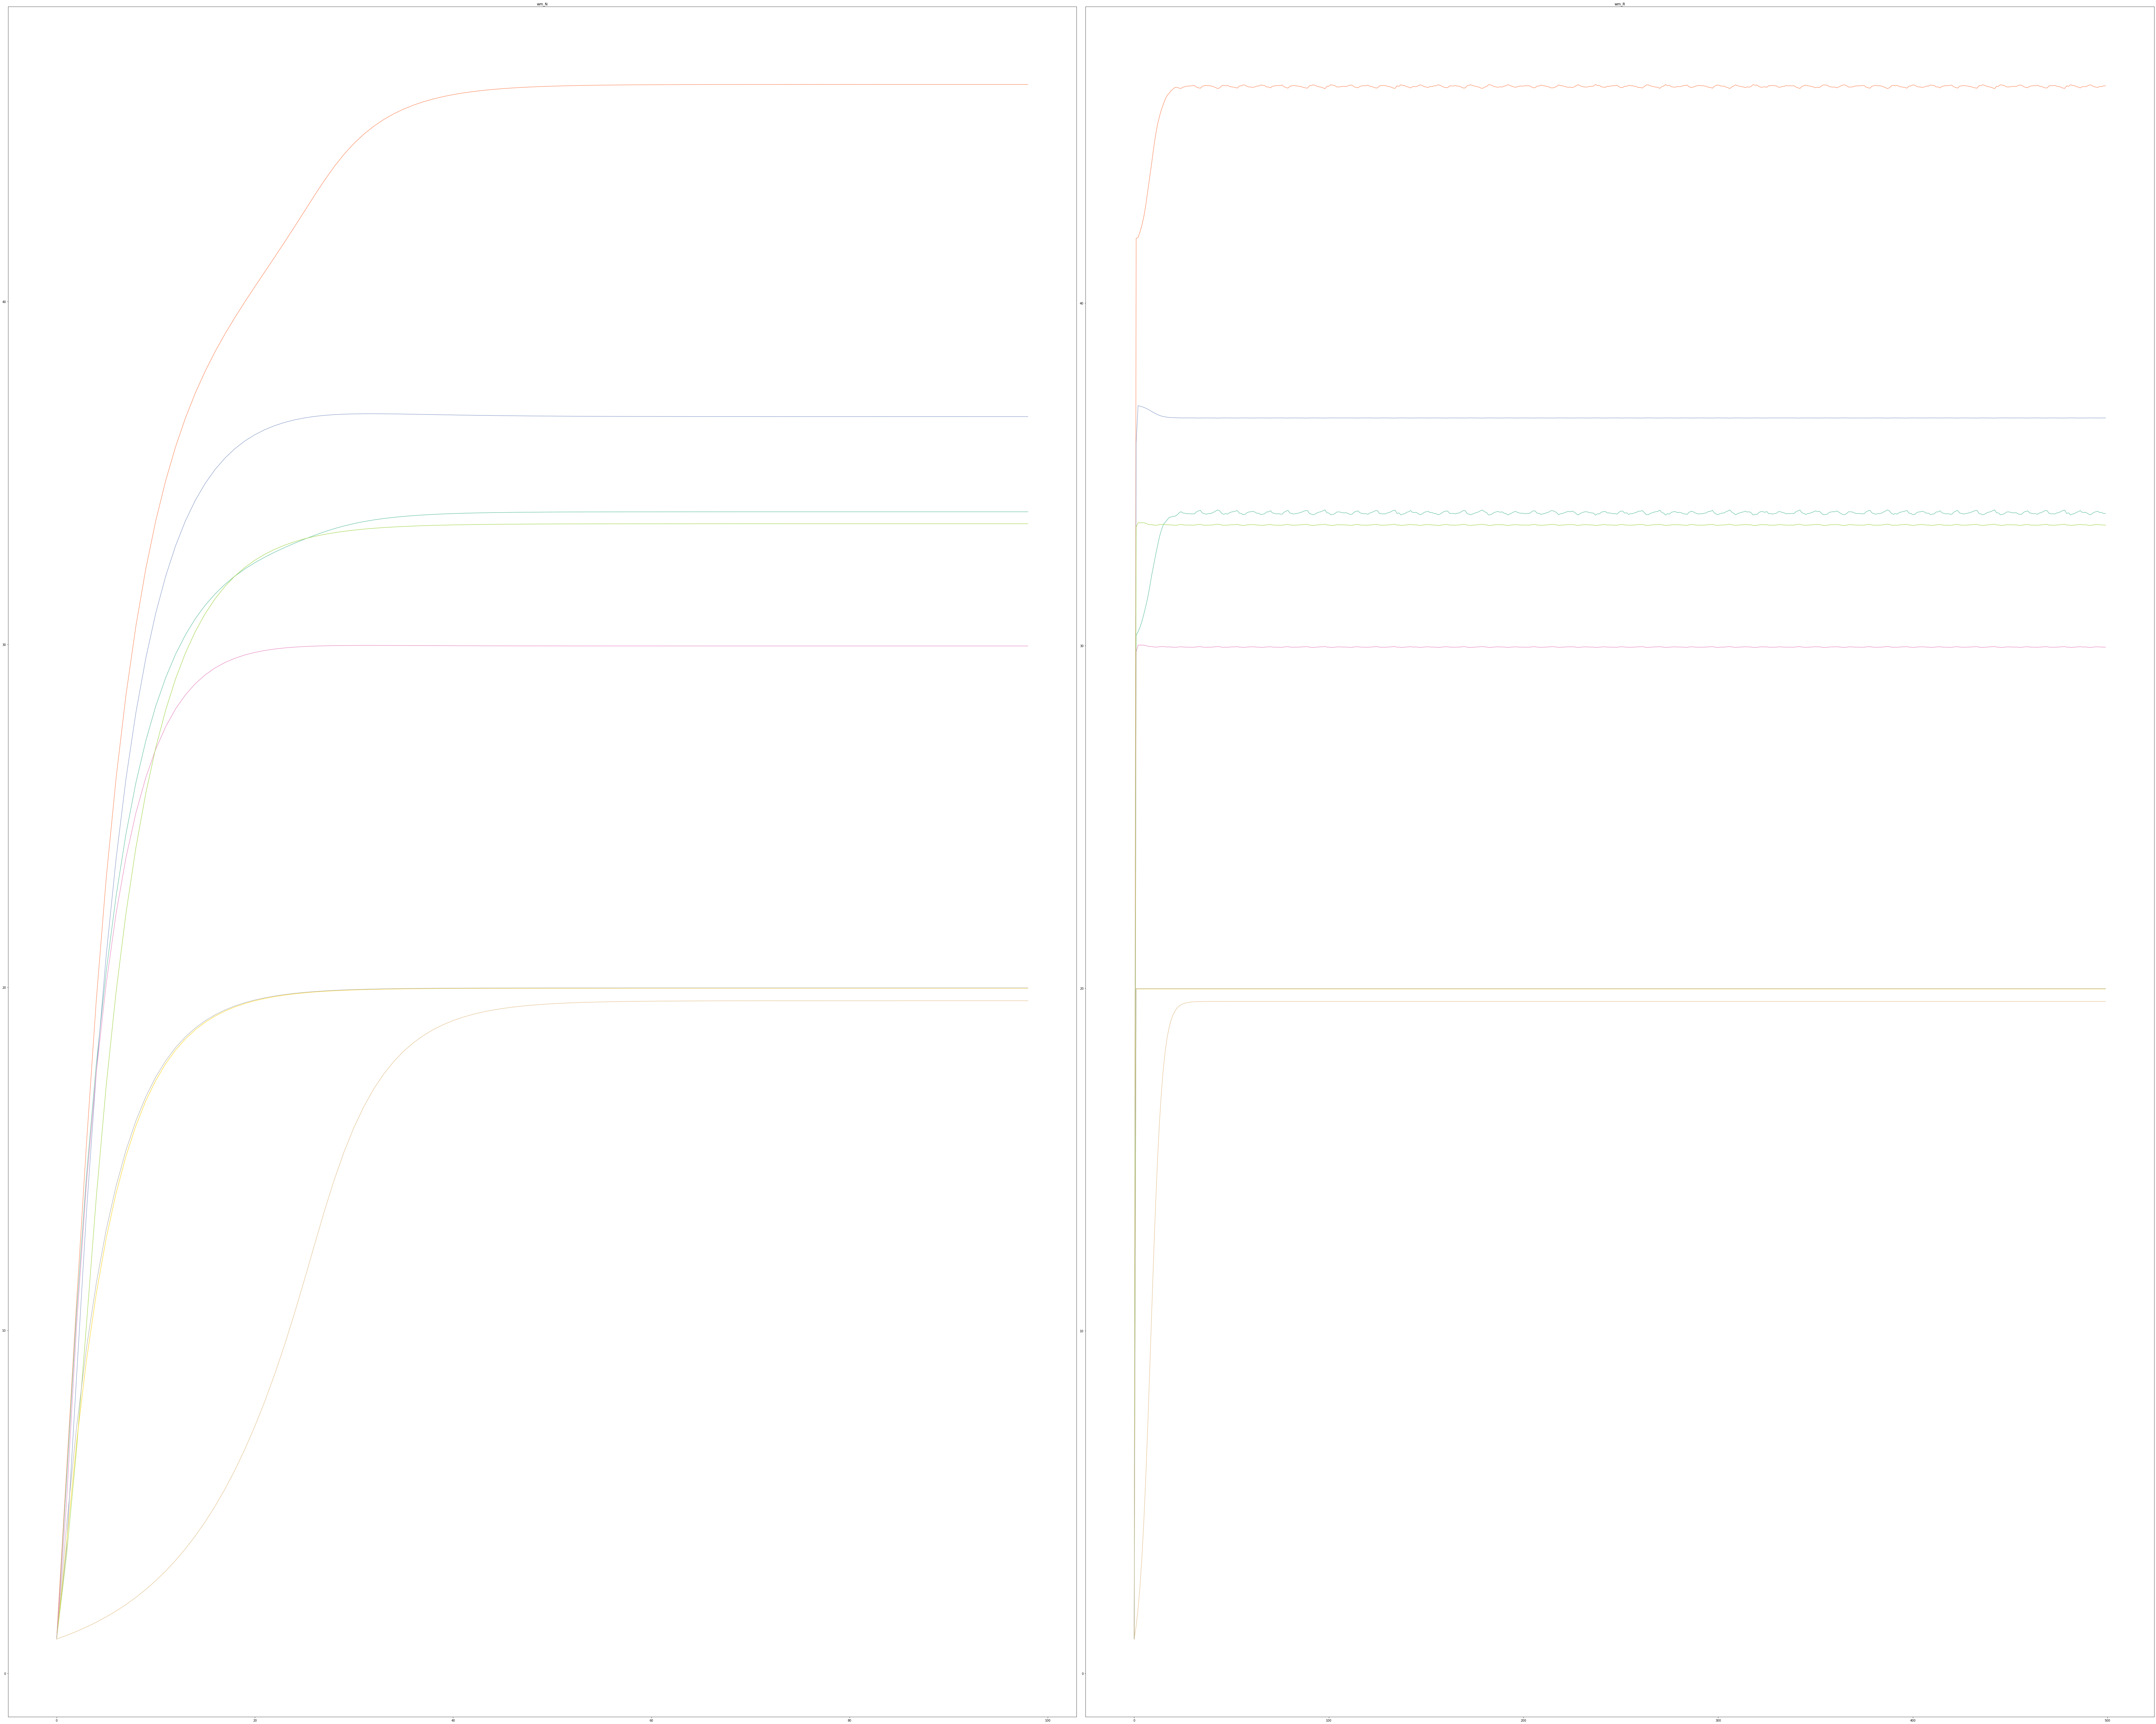

In [26]:

# Extract the matrices for time_series and LV_traj
cr_matrices = [df_complete['N_cr'][i] for i in indexes_random]
lv_matrices = [df_complete['N_lv'][i] for i in indexes_random]

# Create a figure with subplots for each of the matrices (23 rows, 20 columns)
if len(df_complete)==1:
    fig, axes = plt.subplots(len(df_complete), 2, figsize=(100, 80))  # Adjusted figsize for more columns
    # Loop over the axes and the matrices to plot
    for idx, (ax_cr, ax_lv) in enumerate(zip(axes[0::2].flatten(), axes[1::2].flatten())):
    
        # Get the colors for each species based on the index
        species_colors_time_series = plt.cm.Set2.colors[:8]
        resources_colors_time_series = plt.cm.Set2.colors[:df_complete['C'][idx][0].shape[1]]

        # Plot time series
        for i, color in enumerate(species_colors_time_series):
            ax_cr.plot(np.array(cr_matrices[idx])[0][:,i], color=color, label=f'Species {i + 1}')
        ax_cr.set_title('wm_N')
        ax_cr.axis('on')  # Hide axis

        # Plot wm_LV
        for i, color in enumerate(species_colors_time_series):
            ax_lv.plot(lv_matrices[idx][0][i,:], color=color, label=f'Species {i + 1}')
        ax_lv.set_title('wm_R')
        ax_lv.axis('on')  # Hide axis

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()
else:
    if len(df_complete)>=20:
        fig, axes = plt.subplots(5, 8, figsize=(100, 80))  # Adjusted figsize for more columns
    else:
        fig, axes = plt.subplots(len(df_complete), 2, figsize=(100, 80))  # Adjusted figsize for more columns

    # Loop over the axes and the matrices to plot
    for idx, (ax_cr, ax_lv) in enumerate(zip(axes[:, 0::2].flatten(), axes[:, 1::2].flatten())):

        # Get the colors for each species based on the index
        species_colors_time_series = plt.cm.Set2.colors[:8]
        resources_colors_time_series = plt.cm.Set2.colors[:df_complete['C'][idx][0].shape[1]]

        # Plot time series
        for i, color in enumerate(species_colors_time_series):
            ax_cr.plot(np.array(cr_matrices[idx])[0][:,i], color=color, label=f'Species {i + 1}')
        ax_cr.set_title('wm_N')
        ax_cr.axis('on')  # Hide axis

        # Plot wm_LV
        for i, color in enumerate(species_colors_time_series):
            ax_lv.plot(lv_matrices[idx][0][i,:], color=color, label=f'Species {i + 1}')
        ax_lv.set_title('wm_R')
        ax_lv.axis('on')  # Hide axis

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

## Filter for networks with the same actual steady state
Choose the level of accuracy

In [27]:
df_complete['difference'] = [np.abs(matrix[0][:, -1] - matrix2[0][-1]) for matrix,matrix2 in zip(df_complete['N_lv'],df_complete['N_cr'])]
df_filtered = df_complete[(df_complete['difference'].apply(lambda x: (x < 1).all()))]
df_excluded = df_complete[(df_complete['difference'].apply(lambda x: (x >= 1).any()))]
print(len(df_filtered))
print(len(df_excluded))

1
0


Visualize the excluded networks

In [30]:
if len(df_excluded)>20:
    # choose 100 random to plot compared
    import random
    indexes_random = random.sample(list(df_excluded.index), 20)
else:
    indexes_random = df_excluded.index

In [31]:

# Extract the matrices for time_series and LV_traj
cr_matrices = [df_excluded['N_cr'][i] for i in indexes_random]
lv_matrices = [df_excluded['N_lv'][i] for i in indexes_random]

# Create a figure with subplots for each of the matrices (23 rows, 20 columns)
if len(df_excluded>0):
    if len(df_excluded)==1:
        fig, axes = plt.subplots(len(df_complete), 2, figsize=(100, 80))  # Adjusted figsize for more columns
        # Loop over the axes and the matrices to plot
        for idx, (ax_cr, ax_lv) in enumerate(zip(axes[0::2].flatten(), axes[1::2].flatten())):
        
            # Get the colors for each species based on the index
            species_colors_time_series = plt.cm.Set2.colors[:8]
            resources_colors_time_series = plt.cm.Set2.colors[:df_complete['C'][idx][0].shape[1]]

            # Plot time series
            for i, color in enumerate(species_colors_time_series):
                ax_cr.plot(np.array(cr_matrices[idx])[0][:,i], color=color, label=f'Species {i + 1}')
            ax_cr.set_title('wm_N')
            ax_cr.axis('on')  # Hide axis

            # Plot wm_LV
            for i, color in enumerate(species_colors_time_series):
                ax_lv.plot(lv_matrices[idx][0][i,:], color=color, label=f'Species {i + 1}')
            ax_lv.set_title('wm_R')
            ax_lv.axis('on')  # Hide axis

        # Adjust layout
        plt.tight_layout()

        # Show the plot
        plt.show()
    else:
        if len(df_excluded)>=20:
            fig, axes = plt.subplots(5, 8, figsize=(100, 80))  # Adjusted figsize for more columns
        else:
            fig, axes = plt.subplots(len(df_excluded), 2, figsize=(100, 80))  # Adjusted figsize for more columns

        # Loop over the axes and the matrices to plot
        for idx, (ax_cr, ax_lv) in enumerate(zip(axes[:, 0::2].flatten(), axes[:, 1::2].flatten())):

            # Get the colors for each species based on the index
            species_colors_time_series = plt.cm.Set2.colors[:8]
            resources_colors_time_series = plt.cm.Set2.colors[:df_complete['C'][idx][0].shape[1]]

            # Plot time series
            for i, color in enumerate(species_colors_time_series):
                ax_cr.plot(np.array(cr_matrices[idx])[0][:,i], color=color, label=f'Species {i + 1}')
            ax_cr.set_title('wm_N')
            ax_cr.axis('on')  # Hide axis

            # Plot wm_LV
            for i, color in enumerate(species_colors_time_series):
                ax_lv.plot(lv_matrices[idx][0][i,:], color=color, label=f'Species {i + 1}')
            ax_lv.set_title('wm_R')
            ax_lv.axis('on')  # Hide axis

        # Adjust layout
        plt.tight_layout()

        # Show the plot
        plt.show()

# Save df with both CR and LV as a pickle file

In [34]:
# output file path
output_file = '/users/fsibilla/SIBILLA_microbial_ecology_in_space/Data/CR_to_LV_results/CR_to_LV.pkl'
# save as pickle
df_filtered.to_pickle(output_file)